In [1]:
# 第03课：动手实战中文文本中的关键字提取

TF-IDF 的主要思想就是：如果某个词在一篇文档中出现的频率高，也即 TF 高；并且在语料库中其他文档中很少出现，即 DF 低，也即 IDF 高，则认为这个词具有很好的类别区分能力。

TF-IDF 是 Term Frequency - Inverse Document Frequency 的简写
TF 为词频（Term Frequency）
IDF 为逆文档频率（Inverse Document Frequency），表示语料库中包含词 t 的文档的数目的倒数

TF-IDF 倾向于过滤掉常见的词语，保留重要的词语

jieba.analyse.extract_tags(sentence, topK=20, withWeight=False, allowPOS=())

sentence：待提取的文本语料；

topK：返回 TF/IDF 权重最大的关键词个数，默认值为 20；

withWeight：是否需要返回关键词权重值，默认值为 False；

allowPOS：仅包括指定词性的词，默认值为空，即不筛选。

In [2]:
import jieba.analyse
sentence  = "人工智能（Artificial Intelligence），英文缩写为AI。它是研究、开发用于模拟、延伸和扩展人的智能的理论、方法、技术及应用系统的一门新的技术科学。人工智能是计算机科学的一个分支，它企图了解智能的实质，并生产出一种新的能以人类智能相似的方式做出反应的智能机器，该领域的研究包括机器人、语言识别、图像识别、自然语言处理和专家系统等。人工智能从诞生以来，理论和技术日益成熟，应用领域也不断扩大，可以设想，未来人工智能带来的科技产品，将会是人类智慧的“容器”。人工智能可以对人的意识、思维的信息过程的模拟。人工智能不是人的智能，但能像人那样思考、也可能超过人的智能。人工智能是一门极富挑战性的科学，从事这项工作的人必须懂得计算机知识，心理学和哲学。人工智能是包括十分广泛的科学，它由不同的领域组成，如机器学习，计算机视觉等等，总的说来，人工智能研究的一个主要目标是使机器能够胜任一些通常需要人类智能才能完成的复杂工作。但不同的时代、不同的人对这种“复杂工作”的理解是不同的。2017年12月，人工智能入选“2017年度中国媒体十大流行语”。"
keywords = "  ".join(jieba.analyse.extract_tags(sentence , topK=20, withWeight=False, allowPOS=()))
print(keywords)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/yw/k7z_d_3567g16ss9plk47x9w0000gn/T/jieba.cache
Loading model cost 0.788 seconds.
Prefix dict has been built succesfully.


人工智能  智能  2017  机器  不同  人类  科学  模拟  一门  技术  计算机  研究  工作  Artificial  Intelligence  AI  图像识别  12  复杂  流行语


In [3]:
keywords =(jieba.analyse.extract_tags(sentence , topK=10, withWeight=True, allowPOS=(['n','v'])))
print(keywords)

[('人工智能', 0.9750542675762887), ('智能', 0.5167124540885567), ('机器', 0.20540911929525774), ('人类', 0.17414426566082475), ('科学', 0.17250169374402063), ('模拟', 0.15723537382948452), ('技术', 0.14596259315164947), ('计算机', 0.14030483362639176), ('图像识别', 0.12324502580309278), ('流行语', 0.11242211730309279)]


TextRank 是由 PageRank 改进而来，核心思想将文本中的词看作图中的节点，通过边相互连接，不同的节点会有不同的权重，权重高的节点可以作为关键词

In [4]:
result = "  ".join(jieba.analyse.textrank(sentence, topK=20, withWeight=False, allowPOS=('n','v')))
print(result)

智能  人工智能  机器  人类  技术  模拟  包括  科学  理论  计算机  领域  年度  需要  心理学  信息  语言  识别  带来  过程  延伸


通过 Gensim 库完成基于 LDA 的关键字提取。整个过程的步骤为：文件加载 -> jieba 分词 -> 去停用词 -> 构建词袋模型 -> LDA 模型训练 -> 结果可视化。

In [9]:
#引入库文件
import jieba.analyse as analyse
import jieba
import pandas as pd
from gensim import corpora, models, similarities
import gensim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#设置文件路径
dir = "../data/03/"
file_desc = "".join([dir,'car.csv'])
stop_words = "".join([dir,'stopwords.txt'])
#定义停用词
stopwords=pd.read_csv(stop_words,index_col=False,quoting=3,sep="\t",names=['stopword'], encoding='utf-8')
stopwords=stopwords['stopword'].values
#加载语料
df = pd.read_csv(file_desc, encoding='utf-8')
#删除nan行
df.dropna(inplace=True)
lines=df.content.values.tolist()
#开始分词
sentences=[]
for line in lines:
    try:
        segs=jieba.lcut(line)
        segs = [v for v in segs if not str(v).isdigit()]#去数字
        segs = list(filter(lambda x:x.strip(), segs))   #去左右空格
        segs = list(filter(lambda x:x not in stopwords, segs)) #去掉停用词
        sentences.append(segs)
    except Exception:
        print(line)
        continue
#构建词袋模型
dictionary = corpora.Dictionary(sentences)
corpus = [dictionary.doc2bow(sentence) for sentence in sentences]
#lda模型，num_topics是主题的个数，这里定义了5个
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)
#我们查一下第1号分类，其中最常出现的5个词是：
print(lda.print_topic(1, topn=5))
#我们打印所有5个主题，每个主题显示8个词
for topic in lda.print_topics(num_topics=10, num_words=8):
    print(topic[1])

0.019*"汽车" + 0.013*"中国" + 0.009*"企业" + 0.008*"召回" + 0.008*"车展"
0.021*"网约车" + 0.019*"司机" + 0.017*"车辆" + 0.012*"里程" + 0.011*"出租车" + 0.009*"平台" + 0.008*"公里" + 0.007*"驾驶员"
0.019*"汽车" + 0.013*"中国" + 0.009*"企业" + 0.008*"召回" + 0.008*"车展" + 0.007*"一路" + 0.006*"座椅" + 0.006*"一带"
0.017*"汽车" + 0.011*"技术" + 0.010*"智能" + 0.010*"设计" + 0.010*"系统" + 0.009*"驾驶" + 0.007*"体验" + 0.007*"车"
0.029*"品牌" + 0.023*"中国" + 0.022*"车型" + 0.018*"市场" + 0.017*"SUV" + 0.014*"自主" + 0.009*"产品" + 0.007*"全新"
0.019*"易到" + 0.018*"用户" + 0.012*"服务" + 0.008*"租车" + 0.007*"专车" + 0.007*"车辆" + 0.007*"出行" + 0.007*"神州"
0.030*"汽车" + 0.018*"市场" + 0.017*"品牌" + 0.010*"销量" + 0.008*"销售" + 0.008*"新" + 0.007*"经销商" + 0.007*"发展"
0.019*"增长" + 0.017*"同比" + 0.015*"万辆" + 0.012*"数据" + 0.011*"充电" + 0.009*"销量" + 0.009*"汽车" + 0.009*"显示"
0.026*"汽车" + 0.014*"发展" + 0.013*"新能源" + 0.009*"停车" + 0.009*"企业" + 0.008*"中国" + 0.008*"产能" + 0.007*"汽车产业"
0.009*"中" + 0.006*"占" + 0.006*"车辆" + 0.006*"排放" + 0.005*"检测" + 0.005*"销售" + 0.005*"尾气" + 0.004*"经济网"
0.059*"汽车" + 0

In [11]:
dictionary[0]

'一审'

/Users/zhangjianfeng/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


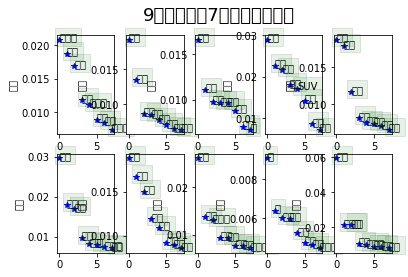

In [12]:
#显示中文matplotlib
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 在可视化部分，我们首先画出了九个主题的7个词的概率分布图
num_show_term = 8 # 每个主题下显示几个词
num_topics  = 10  
for i, k in enumerate(range(num_topics)):
    ax = plt.subplot(2, 5, i+1)
    item_dis_all = lda.get_topic_terms(topicid=k)
    item_dis = np.array(item_dis_all[:num_show_term])
    ax.plot(range(num_show_term), item_dis[:, 1], 'b*')
    item_word_id = item_dis[:, 0].astype(np.int)
    word = [dictionary.id2token[i] for i in item_word_id]
    ax.set_ylabel(u"概率")
    for j in range(num_show_term):
        ax.text(j, item_dis[j, 1], word[j], bbox=dict(facecolor='green',alpha=0.1))
plt.suptitle(u'9个主题及其7个主要词的概率', fontsize=18)
plt.show()

In [13]:
from pyhanlp import *
result = HanLP.extractKeyword(sentence, 20)
print(result)

[人工智能, 智能, 人类, 研究, 不同, 工作, 包括, 领域, 模拟, 理论, 技术, 新的, 门, 机器, 计算机, 科学, 入选, 复杂, AI, 12月]
